In [14]:
import utils.dataset_functions as df
import utils.two_towers as ttn
import utils.metrics as mt
import torch
import numpy as np
from pathlib import Path
import pandas as pd
import random
 
# df path
save_path = Path("results")
save_path.mkdir(parents=True, exist_ok=True)

# Dimensions of the tower FFN
output_dim      = 16
hidden_dim      = 256
id_dim          = 16


device='cuda' if torch.cuda.is_available() else 'cpu'
print("Training models on:", device)

Training models on: cuda


In [2]:
# Load user data
user_item_data = pd.read_csv(Path("dataset") / "processed" / "merged.csv", index_col=False).drop(["normalized_embed"], axis=1)

# Songs is a pre-computed forward pass on all the songs for both 'binary' and 'continueous' models.
songs = torch.load(Path("dataset") / "processed" / "song_subset.pt")
binary_embeddings = songs['binary']
non_binary_embeddings = songs['continueous']

# Load our models
binary_model = model = ttn.DualAugmentedTwoTower("binary_label", hidden_dim, output_dim, id_dim)
binary_model.load(Path("models")/ "binary_label.pt")
non_binary_model = ttn.DualAugmentedTwoTower("continueous_label", hidden_dim, output_dim, id_dim)
non_binary_model.load(Path("models")/ "continueous_label.pt")

# Load test set:
samples = df.load_tensor_dataloader("val", Path("dataset")/"processed", 1, label_id=2)

In [ ]:
# For each user; take the first (it's chronological) test sample, and view it as our present time.
# We extract the user features and embed it using doing a user tower forward pass (model.user_pass)

# And for every other sample for a particular user collect the label and interaction for each song 
# ONLY IF that song has not been listened to before because that would mean it was used for training.
duplicates = 0
users = {}
for user_features, song_embedding, label, interaction, user_id, song_id in samples.dataset:
    #if song_id.item() not in already_seen[user_id.item()]:
        if users.get(user_id.item()) is None:
            users[user_id.item()] = {}
            users[user_id.item()]['user_embed_bin'] = binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['user_embed_nbin'] = non_binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['song_data'] = {song_id.item(): (label.squeeze(0).tolist(), interaction.item())}

        
        else:
            if users[user_id.item()]['song_data'].get(song_id.item()) is not None:
                duplicates += 1
            users[user_id.item()]['song_data'][song_id.item()] = (label.squeeze(0).tolist(), interaction.item())


duplicates

201777

In [5]:
# Create the index for all song embeddings
non_binary_index = np.array([i.tolist() for i in non_binary_embeddings.values()])
binary_index = np.array([i.tolist() for i in binary_embeddings.values()])


non_binary_model.create_index(non_binary_index)
binary_model.create_index(binary_index)

In [6]:
# Now, for each user we make a recommendation of size 'num_rec'. And we score these recommendations using the dot product.

# If a song from the recommendation was ALSO in our test set, we overwrite the base label and interection, 
# which was set at -1 and 0 resprectively as that indicates whether this user has any history with the recommended song.   


# Number of recommendations to make
num_rec = 10
tot_rec = 20

total_users = []
total_nbin_song_ids = []
total_nbin_distances = []
total_nbin_score = []
total_nbin_labels = []
total_nbin_interactions = []

total_bin_song_ids = []
total_bin_distances = []
total_bin_score = []
total_bin_labels = []
total_bin_interactions = []



for u in users.keys():

    user = users[u]

    # 1. Make binary and non-binary recommendations.
    nbin_query = user["user_embed_nbin"][np.newaxis, :]
    nbin_distances, nbin_indices = non_binary_model.recommendations(nbin_query, num_rec)

    bin_query = user["user_embed_bin"][np.newaxis, :]
    bin_distances, bin_indices = binary_model.recommendations(bin_query, num_rec)
    
    # 2. Score them and init the label and interaction lists
    nbin_score  = [(nbin_query * non_binary_embeddings[e]).sum().item() for e in nbin_indices]
    nbin_labels = [0 for _ in range(num_rec)]
    nbin_interactions = [0 for _ in range(num_rec)]

    bin_score = [(bin_query * binary_embeddings[e]).sum().item() for e in bin_indices]
    bin_labels = [0 for _ in range(num_rec)]
    bin_interactions = [0 for _ in range(num_rec)]

   

    
    # 3. Now for both binary and non_binary, check whether each song_id check if it has been listened to before in the test set and overwrite the label and interaction with actual values.
    for i in range(len(nbin_indices)):
        song_id = nbin_indices[i]
        song_data = user["song_data"].get(song_id) 
        
        if song_data is not None:
            nbin_labels[i] = song_data[0][1]
            nbin_interactions[i] = song_data[1]

    
    for i in range(len(bin_indices)):
        song_id = bin_indices[i]
        song_data = user["song_data"].get(song_id) 
        if song_data is not None:
            bin_labels[i] = song_data[0][0]
            bin_interactions[i] = song_data[1]

    
    
    bin_additions = [i for i in user["song_data"].keys() if i not in bin_indices]
    used_i = []
    random.shuffle(bin_additions)
    i = 0

    # First we try to find as much extra songs that we interactions for
    while len(bin_additions) > i and len(bin_indices) < tot_rec:
        song_id = bin_additions[i]
        intr_count = user["song_data"][song_id][1]
        if intr_count != 0:
            
            song_embed = binary_embeddings[song_id]
            label = user["song_data"][song_id][0][0]
            distance = binary_model.query_item_distance(bin_query, song_embed)
            score = (bin_query * song_embed).sum().item()
            
            
            bin_indices.append(song_id)
            bin_distances.append(distance)
            bin_score.append(score)
            bin_labels.append(label)
            bin_interactions.append(intr_count)

            used_i.append(i)

        i += 1

    i = 0
    # Then we make additions of songs we have labels for
    while len(bin_additions) > i and len(bin_indices) < tot_rec:
        if i not in used_i:
            song_id = bin_additions[i]
            intr_count = user["song_data"][song_id][1]
                
            song_embed = binary_embeddings[song_id]
            label = user["song_data"][song_id][0][0]
            distance = binary_model.query_item_distance(bin_query, song_embed)
            score = (bin_query * song_embed).sum().item()
            
            
            bin_indices.append(song_id)
            bin_distances.append(distance)
            bin_score.append(score)
            bin_labels.append(label)
            bin_interactions.append(intr_count)
            used_i.append(i)

        i += 1

    i = 0
    
    # Lastly, as a last resort we fill up to 20 with songs we don´t know anything about
    bin_additions = [i for i in binary_embeddings.keys() if i not in nbin_indices]
    while len(bin_indices) < tot_rec: # We add thing that have no interaction but do have labels.
        if i not in used_i:
            song_id = bin_additions[i]
            intr_count = 0
            
                
            song_embed = binary_embeddings[song_id]
            label = 0
            distance = binary_model.query_item_distance(bin_query, song_embed)
            score = (bin_query * song_embed).sum().item()
            
            
            bin_indices.append(song_id)
            bin_distances.append(distance)

            bin_score.append(score)
            bin_labels.append(label)
            bin_interactions.append(intr_count)
        
        i += 1
            
        




    nbin_additions = [i for i in user["song_data"].keys() if i not in nbin_indices]
    used_i = []
    random.shuffle(nbin_additions)
    i = 0
    while len(nbin_additions) > i and len(nbin_indices) < tot_rec:
        song_id = nbin_additions[i]
        intr_count = user["song_data"][song_id][1]
        if intr_count != 0:
            
            song_embed = non_binary_embeddings[song_id]
            label = user["song_data"][song_id][0][1]
            distance = non_binary_model.query_item_distance(nbin_query, song_embed)
            score = (nbin_query * song_embed).sum().item()
            
            
            nbin_indices.append(song_id)
            nbin_distances.append(distance)
            nbin_score.append(score)
            nbin_labels.append(label)
            nbin_interactions.append(intr_count)

            used_i.append(i)
            

        i += 1

    i = 0
    while len(nbin_additions) > i and len(nbin_indices) < tot_rec:
        if i not in used_i:
            song_id = nbin_additions[i]
            intr_count = user["song_data"][song_id][1]
    
                
            song_embed = non_binary_embeddings[song_id]
            label = user["song_data"][song_id][0][1]
            distance = non_binary_model.query_item_distance(nbin_query, song_embed)
            score = (nbin_query * song_embed).sum().item()
            
            
            nbin_indices.append(song_id)
            nbin_distances.append(distance)
            nbin_score.append(score)
            nbin_labels.append(label)
            nbin_interactions.append(intr_count)

            used_i.append(i)
                

        i += 1
    
    nbin_additions = [i for i in non_binary_embeddings.keys() if i not in nbin_indices]
    random.shuffle(nbin_additions)
    i = 0
    while len(nbin_indices) < tot_rec: # We add thing that have no interaction but do have labels.
        if i not in used_i:
            song_id = bin_additions[i]
            intr_count = 0
            
                
            song_embed = non_binary_embeddings[song_id]
            label = 0
            distance = non_binary_model.query_item_distance(nbin_query, song_embed)
            score = (nbin_query * song_embed).sum().item()
            

            
            nbin_indices.append(song_id)
            nbin_distances.append(distance)
            nbin_score.append(score)
            nbin_labels.append(label)
            nbin_interactions.append(intr_count)
            
        i += 1







    # Add the total together for our dataframes
    total_users += [u for _ in range(len(bin_indices))]
    total_nbin_song_ids += nbin_indices
    total_nbin_distances += nbin_distances
    total_nbin_score += nbin_score
    total_nbin_labels += nbin_labels
    total_nbin_interactions += nbin_interactions

    total_bin_song_ids += bin_indices
    total_bin_distances += bin_distances
    total_bin_score += bin_score
    total_bin_labels += bin_labels
    total_bin_interactions += bin_interactions
    

In [7]:
bin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_bin_song_ids,
                    "distances": total_bin_distances,
                    "score": total_bin_score,
                    "label": total_bin_labels,
                    "interaction": total_bin_interactions
            })

dic = bin_df['label'].value_counts().to_dict()

# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 96%

# Met 25 rec:
# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

total = 0
labels = 0

for l, c in dic.items():
    total += c
    if l != -1:
        labels += c 


labels/total 

1.0

In [8]:
bin_df[bin_df['uid']== 4485].sort_values('score', ascending=False)

,uid,song_id,distances,score,label,interaction
6,4485,280,3.439622,0.769442,0.0,0
7,4485,889,3.444928,0.566934,0.0,0
1,4485,667,2.900033,0.504869,0.0,0
5,4485,305,3.403291,0.444360,0.0,0
2,4485,1108,3.097033,0.397719,0.0,0
4,4485,450,3.353680,0.327991,0.0,0
3,4485,490,3.351879,0.290814,0.0,0
8,4485,1631,3.566291,0.278651,0.0,0
9,4485,643,3.589037,0.230947,0.0,0
11,4485,2282,6.445309,0.226621,1.0,1


In [9]:
nbin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_nbin_song_ids,
                    "distances": total_nbin_distances,
                    "score": total_nbin_score,
                    "label": total_nbin_labels,
                    "interaction": total_nbin_interactions
            })

dic = nbin_df['label'].value_counts().to_dict()

# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

# Met 25 rec:
# met train filter:     -1 count = 99%
# zonder train filter:  -1 count = 95%

total = 0
labels = 0

for l, c in dic.items():
    total += c
    if l != -1:
        labels += c 


labels/total 

1.0

In [10]:
nbin_df

,uid,song_id,distances,score,label,interaction
0,4485,2392,1.677190,0.893750,0.00,0
1,4485,19,1.748108,0.824787,0.24,0
2,4485,183,1.858885,0.558120,0.00,0
3,4485,1012,1.916937,1.096835,0.00,0
4,4485,0,2.003084,0.000000,0.00,0
...,...,...,...,...,...,...
105895,2465,1097,5.304231,0.173198,0.50,1
105896,2465,1127,4.121332,0.213445,1.00,1
105897,2465,3180,7.210283,0.602372,1.00,1
105898,2465,2714,6.842731,-0.351211,0.12,1


In [11]:
# Save our df's
bin_df.to_csv(save_path / "bin_df.csv", index=False)
nbin_df.to_csv(save_path/ "nbin_df.csv", index=False)

In [17]:
import utils.dataset_functions as df
import utils.two_towers as ttn
import utils.metrics as mt
import torch
import numpy as np
from pathlib import Path
import pandas as pd

# df path
save_path = Path("results")
save_path.mkdir(parents=True, exist_ok=True)

# Dimensions of the tower FFN
output_dim      = 16
hidden_dim      = 256
id_dim          = 16


device='cuda' if torch.cuda.is_available() else 'cpu'
print("Training models on:", device)

# Load our df's like so:
bin_df = pd.read_csv(save_path / "bin_df.csv", index_col=False)
nbin_df= pd.read_csv(save_path/ "nbin_df.csv", index_col=False)

Training models on: cuda


In [26]:
bin_rankings = []
nbin_rankings = []
for u in bin_df['uid'].unique():
    temp = bin_df[bin_df['uid'] == u].sort_values('score', ascending=False)
    if temp['interaction'].sum() > 0:
        bin_rankings.append(temp['interaction'].to_list())

for u in nbin_df['uid'].unique():
    temp = nbin_df[nbin_df['uid'] == u].sort_values('score', ascending=False)
    if temp['interaction'].sum() > 0:
        nbin_rankings.append(temp['interaction'].to_list())


In [27]:
bin_rankings = np.array(bin_rankings)
nbin_rankings = np.array(nbin_rankings)
bin_scores = []
for val in bin_rankings:
    bin_scores.append(mt.metrics(val, [20]))
    
nbin_scores = []
for val in nbin_rankings:
    nbin_scores.append(mt.metrics(val, [20]))
    
binary_scores = np.array(bin_scores)
non_binary_scores = np.array(nbin_scores)

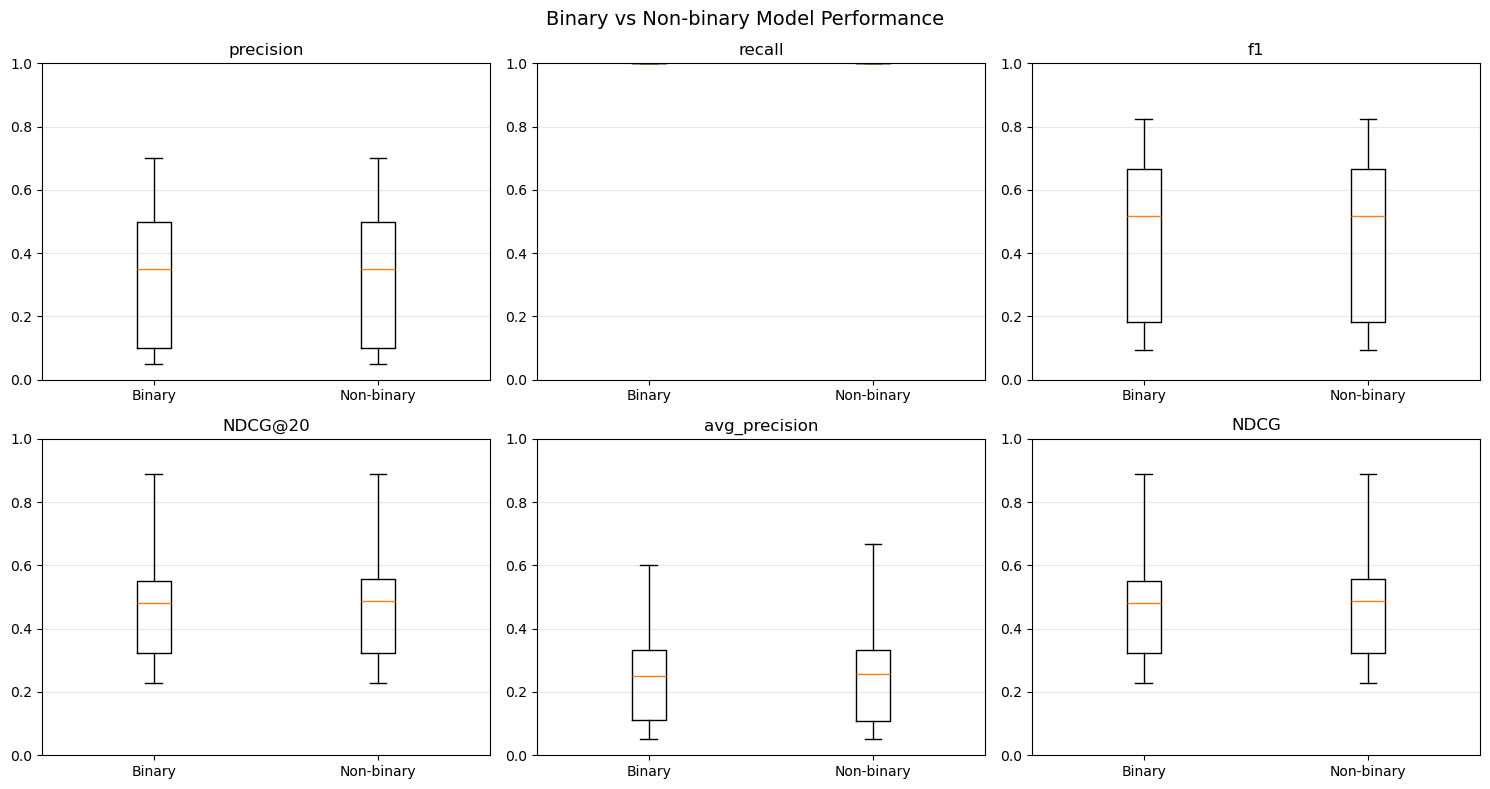

In [28]:
import matplotlib.pyplot as plt

metrics = ["precision", "recall", "f1", "NDCG@20", "avg_precision", "NDCG"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.boxplot(
        [binary_scores[:, i], non_binary_scores[:, i]],
        tick_labels=["Binary", "Non-binary"],
        showfliers=False
    )

    ax.set_title(metrics[i])
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)

fig.suptitle("Binary vs Non-binary Model Performance", fontsize=14)
plt.tight_layout()
plt.show()
